In [1]:
import os
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import cv2
from collections import Counter
from sklearn.metrics import accuracy_score

In [2]:
folder_path = '/kaggle/input/frames-10fps/frames'  # Replace with your folder path


In [3]:
folders=sorted(os.listdir(folder_path))
train_folder=folders[:23]
test_folder=folders[23:]

In [4]:
train_paths=[]
for i in tqdm(range(len(train_folder))):
    files=os.listdir(os.path.join(folder_path,folders[i]))
    files.sort(key=lambda x: int(x.split('.')[0]))
    files=[os.path.join(folder_path,folders[i],files[j]) for j in range(len(files))]
    train_paths=train_paths+files
test_paths=[]
for i in tqdm(range(len(test_folder))):
    files=os.listdir(os.path.join(folder_path,folders[i]))
    files.sort(key=lambda x: int(x.split('.')[0]))
    files=[os.path.join(folder_path,folders[i],files[j]) for j in range(len(files))]
    test_paths=test_paths+files

100%|██████████| 4/4 [00:00<00:00, 102.60it/s]


In [5]:
def get_csv_id(file_path):

    # Extract the filename without extension
    filename = os.path.basename(file_path)  # RightVideoSN001.csv

    # Extract the identifier ('1' or '11')
    if filename.startswith('RightVideoSN'):
        identifier = filename[len('RightVideoSN'):]  # Get '001' or '011'
        identifier = identifier.lstrip('0').split('.')[0]  # Remove leading zeros

    return int(identifier)
def get_id(path):

    # Split the path by '/'
    parts = path.split('/')

    # Get the directory name that contains the image
    dirname = parts[-2]  # RightVideoSN011

    # Extract the relevant parts from the directory name
    if dirname.startswith('RightVideoSN'):
        identifier = dirname[len('RightVideoSN'):]  # Get SN011 -> 011
        identifier = identifier.lstrip('0')  # Remove leading zeros

    # Get the image number from the filename
    filename = parts[-1]  # 240.jpg
    image_number = os.path.splitext(filename)[0]  # 240

    return int(identifier),int(image_number)

In [6]:
folder_path = '/kaggle/input/labels-csv/labels_csv'
csv_path=[]
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        csv_path.append(file_path)
csv_path=sorted(csv_path)
csv={}
for file in csv_path:
    df=pd.read_csv(file)
    ide=get_csv_id(file)
    csv[ide]=df

In [7]:
col=csv[1].columns
col

Index(['au1', 'au12', 'au15', 'au17', 'au2', 'au20', 'au25', 'au26', 'au4',
       'au5', 'au6', 'au9'],
      dtype='object')

In [8]:
labels=[]
for file in tqdm(train_paths):
    ide,image=get_id(file)
    try:
        label=np.array(csv[ide].iloc[image])
        label[label > 0]=1
        labels.append(label)
    except IndexError as e:
        print(f"IndexError occurred: {ide}")
        print(f"Check ide={ide} and image={image} against csv indices.")
labels=np.array(labels)

100%|██████████| 55728/55728 [00:03<00:00, 14337.90it/s]


In [9]:
test_labels=[]
for file in tqdm(test_paths):
    ide,image=get_id(file)
    try:
        label=np.array(csv[ide].iloc[image])
        label[label > 0]=1
        test_labels.append(label)
    except IndexError as e:
        print(f"IndexError occurred: {ide}")
        print(f"Check ide={ide} and image={image} against csv indices.")
test_labels=np.array(test_labels)

100%|██████████| 9692/9692 [00:00<00:00, 13206.98it/s]


In [10]:
for i in range(12):
    print(Counter(labels[:,i]))

Counter({0: 52661, 1: 3067})
Counter({0: 42644, 1: 13084})
Counter({0: 52166, 1: 3562})
Counter({0: 49785, 1: 5943})
Counter({0: 53360, 1: 2368})
Counter({0: 53835, 1: 1893})
Counter({0: 36680, 1: 19048})
Counter({0: 46325, 1: 9403})
Counter({0: 45560, 1: 10168})
Counter({0: 54530, 1: 1198})
Counter({0: 47255, 1: 8473})
Counter({0: 52760, 1: 2968})


In [11]:
zero_indices = np.where(~labels.any(axis=1))[0]
nz=np.where(labels.any(axis=1))[0]
print("Indices where all elements in rows are zero:",len(zero_indices))
print("Indices where all elements in rows are all not  zero:",len(nz))

Indices where all elements in rows are zero: 20986
Indices where all elements in rows are all not  zero: 34742


In [12]:
random_numbers = np.random.choice(zero_indices, size=4000, replace=False)
mask=np.concatenate((random_numbers,nz))
mask.sort()

In [13]:
sam_labels=labels[mask]
sam_labels.shape

(38742, 12)

In [14]:
frames=[]
target_size=(224, 224)
for i in tqdm(range(len(train_paths))):
    if i in mask:
        img=cv2.imread(train_paths[i],0)
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        rgb_image = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
        frames.append(rgb_image)

100%|██████████| 55728/55728 [05:05<00:00, 182.57it/s]


In [15]:
test_frames=[]
target_size=(224, 224)
for i in tqdm(range(len(test_paths))):
    if True:
        img=cv2.imread(test_paths[i],0)
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        rgb_image = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
        test_frames.append(rgb_image)

100%|██████████| 9692/9692 [00:30<00:00, 318.77it/s]


In [16]:
from tensorflow.keras.metrics import AUC
pr_metric = AUC(curve='PR', num_thresholds=1000)

import tensorflow as tf
from sklearn.metrics import average_precision_score

def sk_pr_auc(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)

2024-07-16 05:19:44.041278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 05:19:44.041403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 05:19:44.179748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Define epsilon to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        # Clip predictions to prevent log(0) and log(1 - 0)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        # Compute the focal loss
        fl = - alpha * (y_true * (1 - y_pred)**gamma * tf.math.log(y_pred)
                       + (1 - y_true) * (y_pred**gamma) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(fl, axis=-1)
    return focal_loss

loss = binary_focal_loss(gamma=3.0, alpha=0.3)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from transformers import TFViTModel, ViTFeatureExtractor

# Custom Keras layer for ViT
class ViTFeatureExtractorLayer(tf.keras.layers.Layer):
    def __init__(self, model_name='google/vit-base-patch16-224', **kwargs):
        super(ViTFeatureExtractorLayer, self).__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    
    def call(self, inputs):
        # Normalize the inputs to the range [0, 1] expected by the ViT
        inputs = tf.cast(inputs, tf.float32) / 255.0
        # Resize and preprocess the image using TensorFlow operations
        inputs = tf.image.resize(inputs, (224, 224))
        inputs = tf.transpose(inputs, [0, 3, 1, 2])  # ViT expects channels-first format
        outputs = self.vit(inputs).last_hidden_state
        # Global average pooling on the output features
        outputs = tf.reduce_mean(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 768)  # 768 is the hidden size of the ViT base model

# Define the model architecture
inputs = Input(shape=(224, 224, 3))
x = ViTFeatureExtractorLayer()(inputs)

# Add custom dense network on top of ViT features
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Second dense layer
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Third dense layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Fourth dense layer
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Fifth dense layer
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Output layer
outputs = Dense(12, activation='sigmoid')(x)  # 12 output labels for multi-label classification

# Create the model
model = Model(inputs, outputs)

# Compile the model
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy',pr_metric])

# Model summary
model.summary()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_feature_extractor_layer    │ (None, 768)            │             0 │
│ (ViTFeatureExtractorLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,452 (5.70 MB)

 Trainable params: 1,489,484 (5.68 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [19]:
history=model.fit(np.array(frames),sam_labels,
          epochs=100,
          batch_size=32,
          verbose=1,
          validation_data=(np.array(test_frames),test_labels))


Epoch 1/100


I0000 00:00:1721107256.906549      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721107256.953786      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1211/1211 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.2826 - auc: 0.4903 - loss: 0.0238

W0000 00:00:1721107484.894297      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721107496.825009      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1211/1211 ━━━━━━━━━━━━━━━━━━━━ 327s 244ms/step - accuracy: 0.2826 - auc: 0.4904 - loss: 0.0237 - val_accuracy: 0.2326 - val_auc: 0.8537 - val_loss: 0.0070
Epoch 2/100


W0000 00:00:1721107552.759291      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1211/1211 ━━━━━━━━━━━━━━━━━━━━ 276s 220ms/step - accuracy: 0.3935 - auc: 0.8343 - loss: 0.0088 - val_accuracy: 0.2658 - val_auc: 0.8866 - val_loss: 0.0064
Epoch 3/100
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 267s 220ms/step - accuracy: 0.4238 - auc: 0.8750 - loss: 0.0075 - val_accuracy: 0.2532 - val_auc: 0.8826 - val_loss: 0.0065
Epoch 4/100
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 322s 220ms/step - accuracy: 0.4350 - auc: 0.8973 - loss: 0.0067 - val_accuracy: 0.2602 - val_auc: 0.9274 - val_loss: 0.0049
Epoch 5/100
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 267s 220ms/step - accuracy: 0.4297 - auc: 0.9092 - loss: 0.0063 - val_accuracy: 0.2964 - val_auc: 0.9448 - val_loss: 0.0045
Epoch 6/100
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 267s 220ms/step - accuracy: 0.4433 - auc: 0.9194 - loss: 0.0059 - val_accuracy: 0.2601 - val_auc: 0.9380 - val_loss: 0.0045
Epoch 7/100
1211/1211 ━━━━━━━━━━━━━━━━━━━━ 267s 220ms/step - accuracy: 0.4500 - auc: 0.9262 - loss: 0.0057 - val_accuracy: 0.2893 - val_auc: 0.9542 - val_loss: 0.0038
Epoch 8/10

In [20]:
pred=model.predict(np.array(test_frames))

  2/303 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step

W0000 00:00:1721135608.713411      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


303/303 ━━━━━━━━━━━━━━━━━━━━ 61s 188ms/step


W0000 00:00:1721135665.455303      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


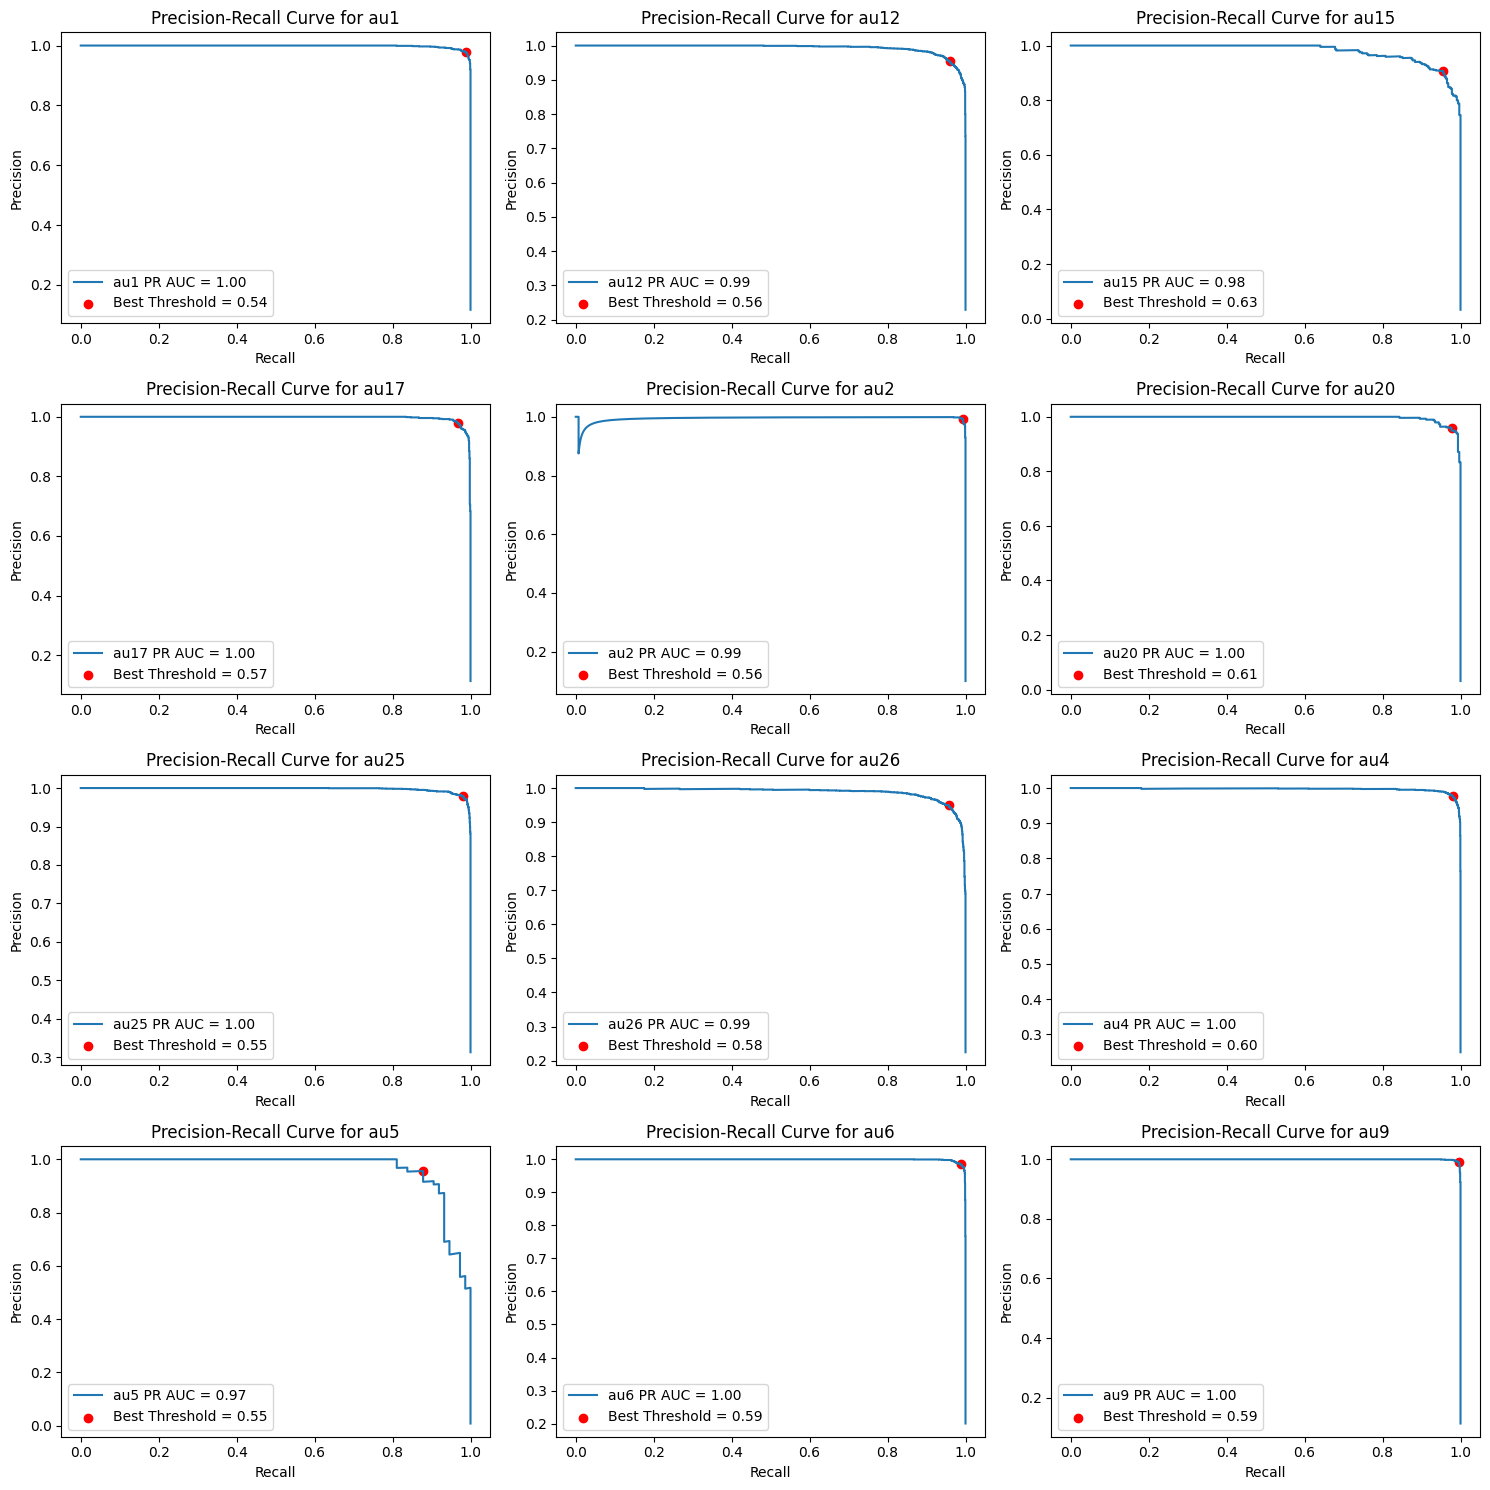

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Assuming y_test contains the true binary labels and pred contains the predicted probabilities
# au contains the names of the action units or labels
au = csv[1].columns
t=[]
# Create a figure and a grid of subplots (4x3)
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easier indexing

# Loop through each label
for i in range(12):
    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(test_labels[:, i], pred[:, i])

    # Calculate the precision-recall AUC
    pr_auc = auc(recall, precision)

    # Compute F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the threshold that maximizes the F1 score
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    t.append(best_threshold)
    best_f1 = f1_scores[best_threshold_index]

    # Plot the precision-recall curve
    ax = axes[i]
    ax.plot(recall, precision, label=f'{au[i]} PR AUC = {pr_auc:.2f}')
    ax.scatter(recall[best_threshold_index], precision[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {au[i]}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [22]:
y_pred = (pred >= t).astype(int)

Accuracy of each action unit 
au1   :  0.9961824184894759
au12   :  0.9802930251754024
au15   :  0.9953569954601733
au17   :  0.9941188609162196
au2   :  0.9985555096987206
au20   :  0.9979364424267437
au25   :  0.9874122988031366
au26   :  0.9789517127527858
au4   :  0.9892695006190673
au5   :  0.9987618654560462
au6   :  0.9946347503095336
au9   :  0.998349153941395


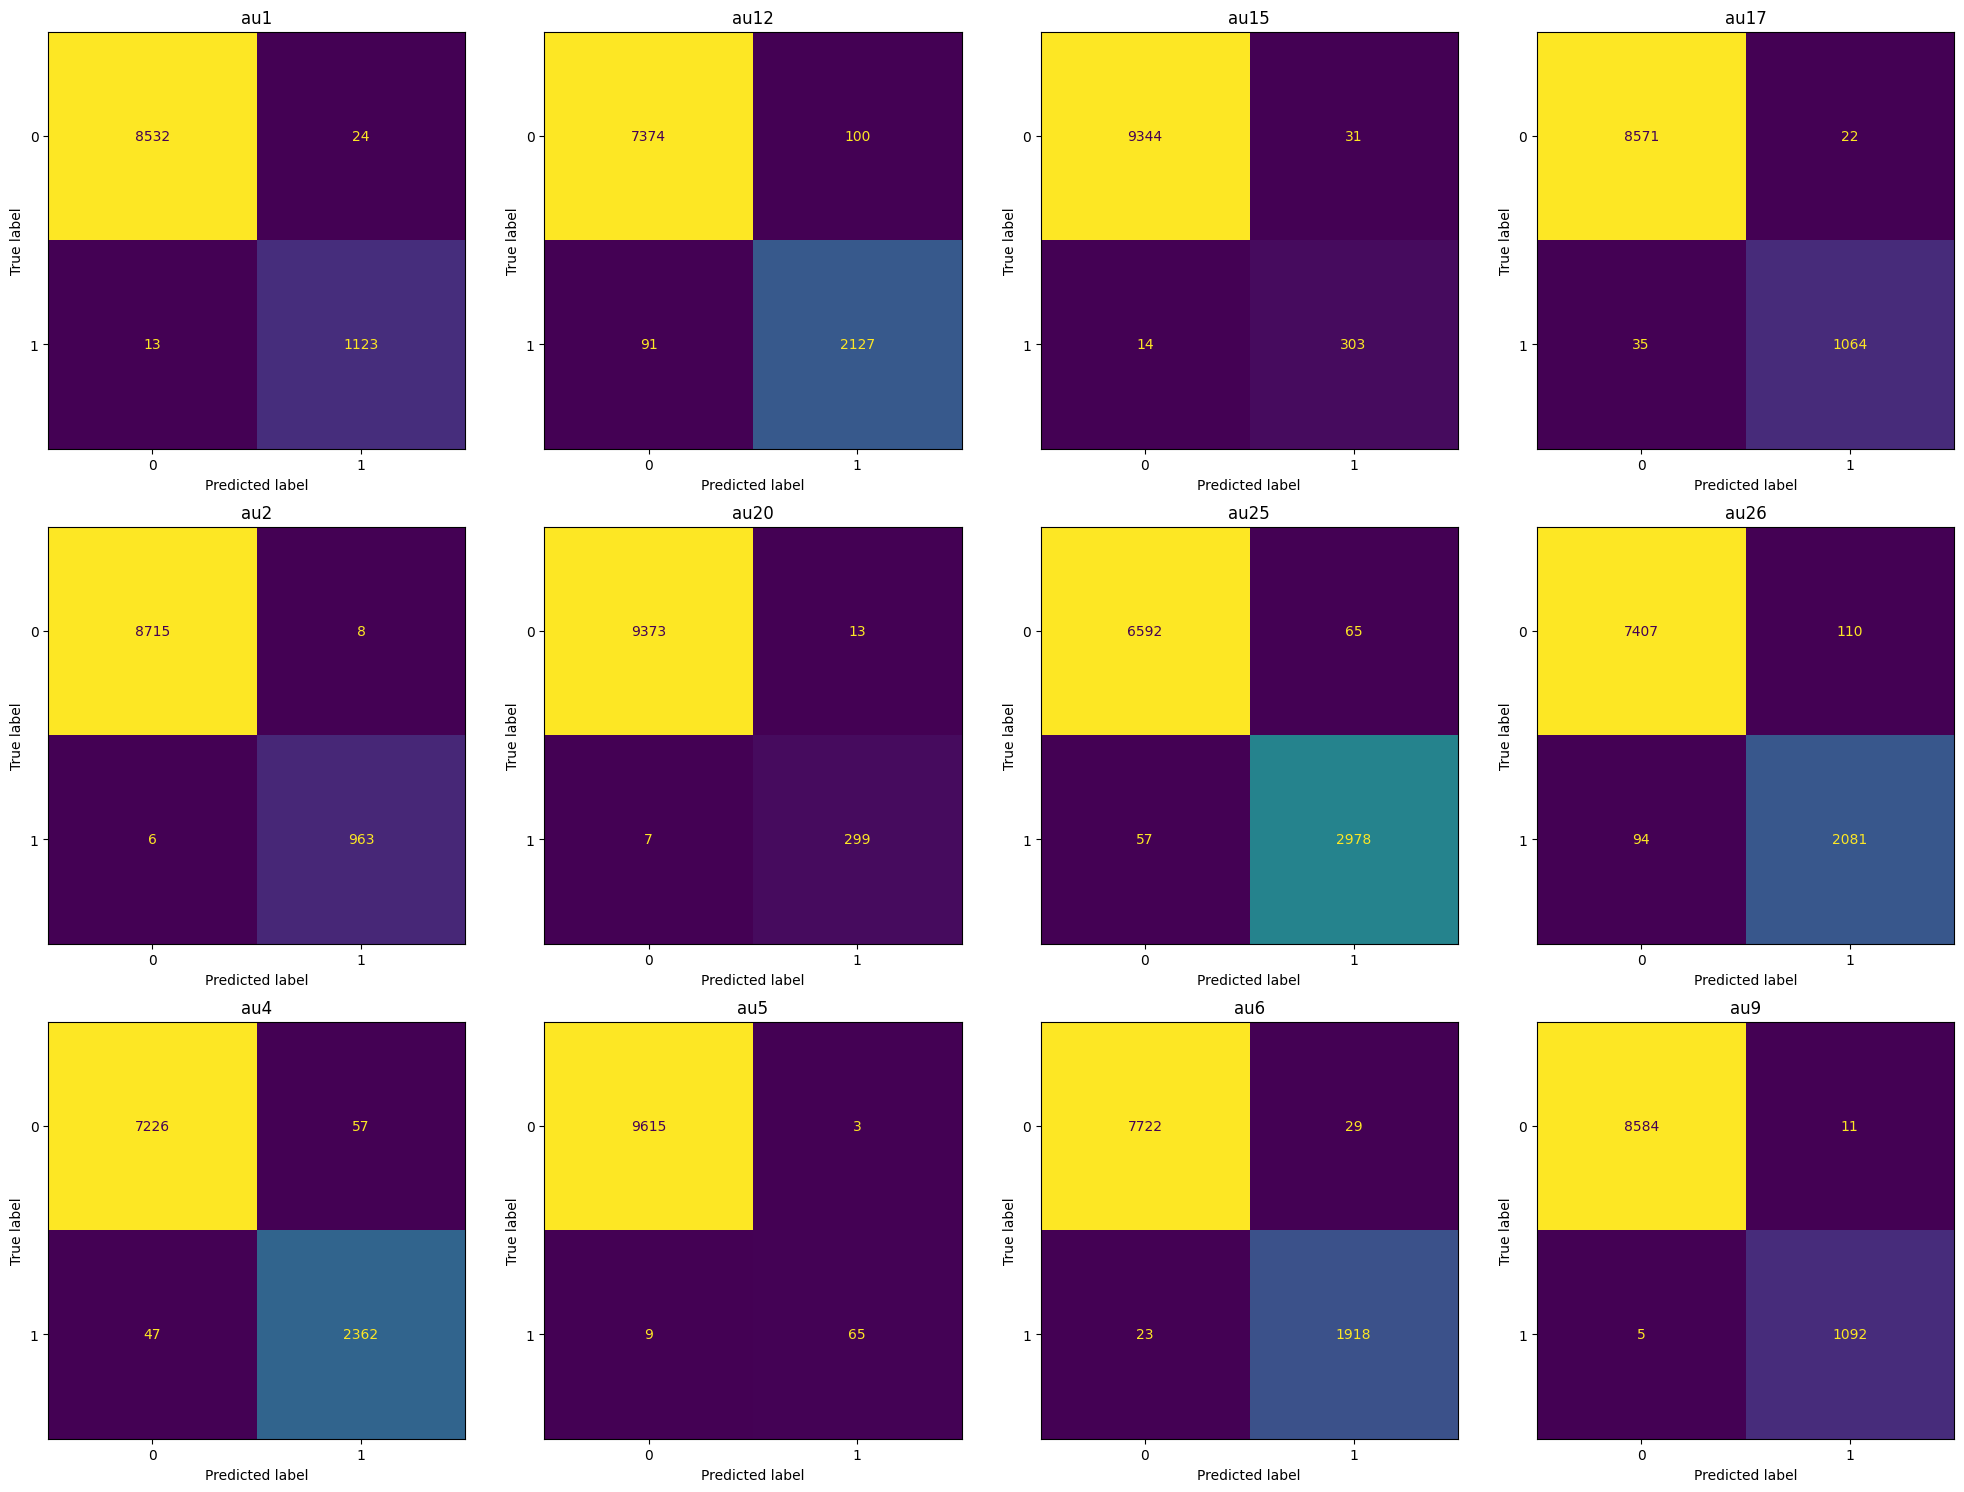

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
p=y_pred
print("Accuracy of each action unit ")

for i in range(12):
    print(f'{au[i] }   : ', accuracy_score(test_labels[:, i], p[:, i]))
for i in range(12):
    cm = confusion_matrix(test_labels[:, i], p[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(au[i])

# Adjust layout
plt.tight_layout()
plt.show()

In [24]:
test_frames=np.array(test_frames)

71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step


W0000 00:00:1721135830.501416      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step


W0000 00:00:1721135837.532516      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step


W0000 00:00:1721135853.002100      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step


W0000 00:00:1721135867.392506      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step


W0000 00:00:1721135874.089993      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/190 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step


W0000 00:00:1721135936.835980      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 169ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step


W0000 00:00:1721135990.601093      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step


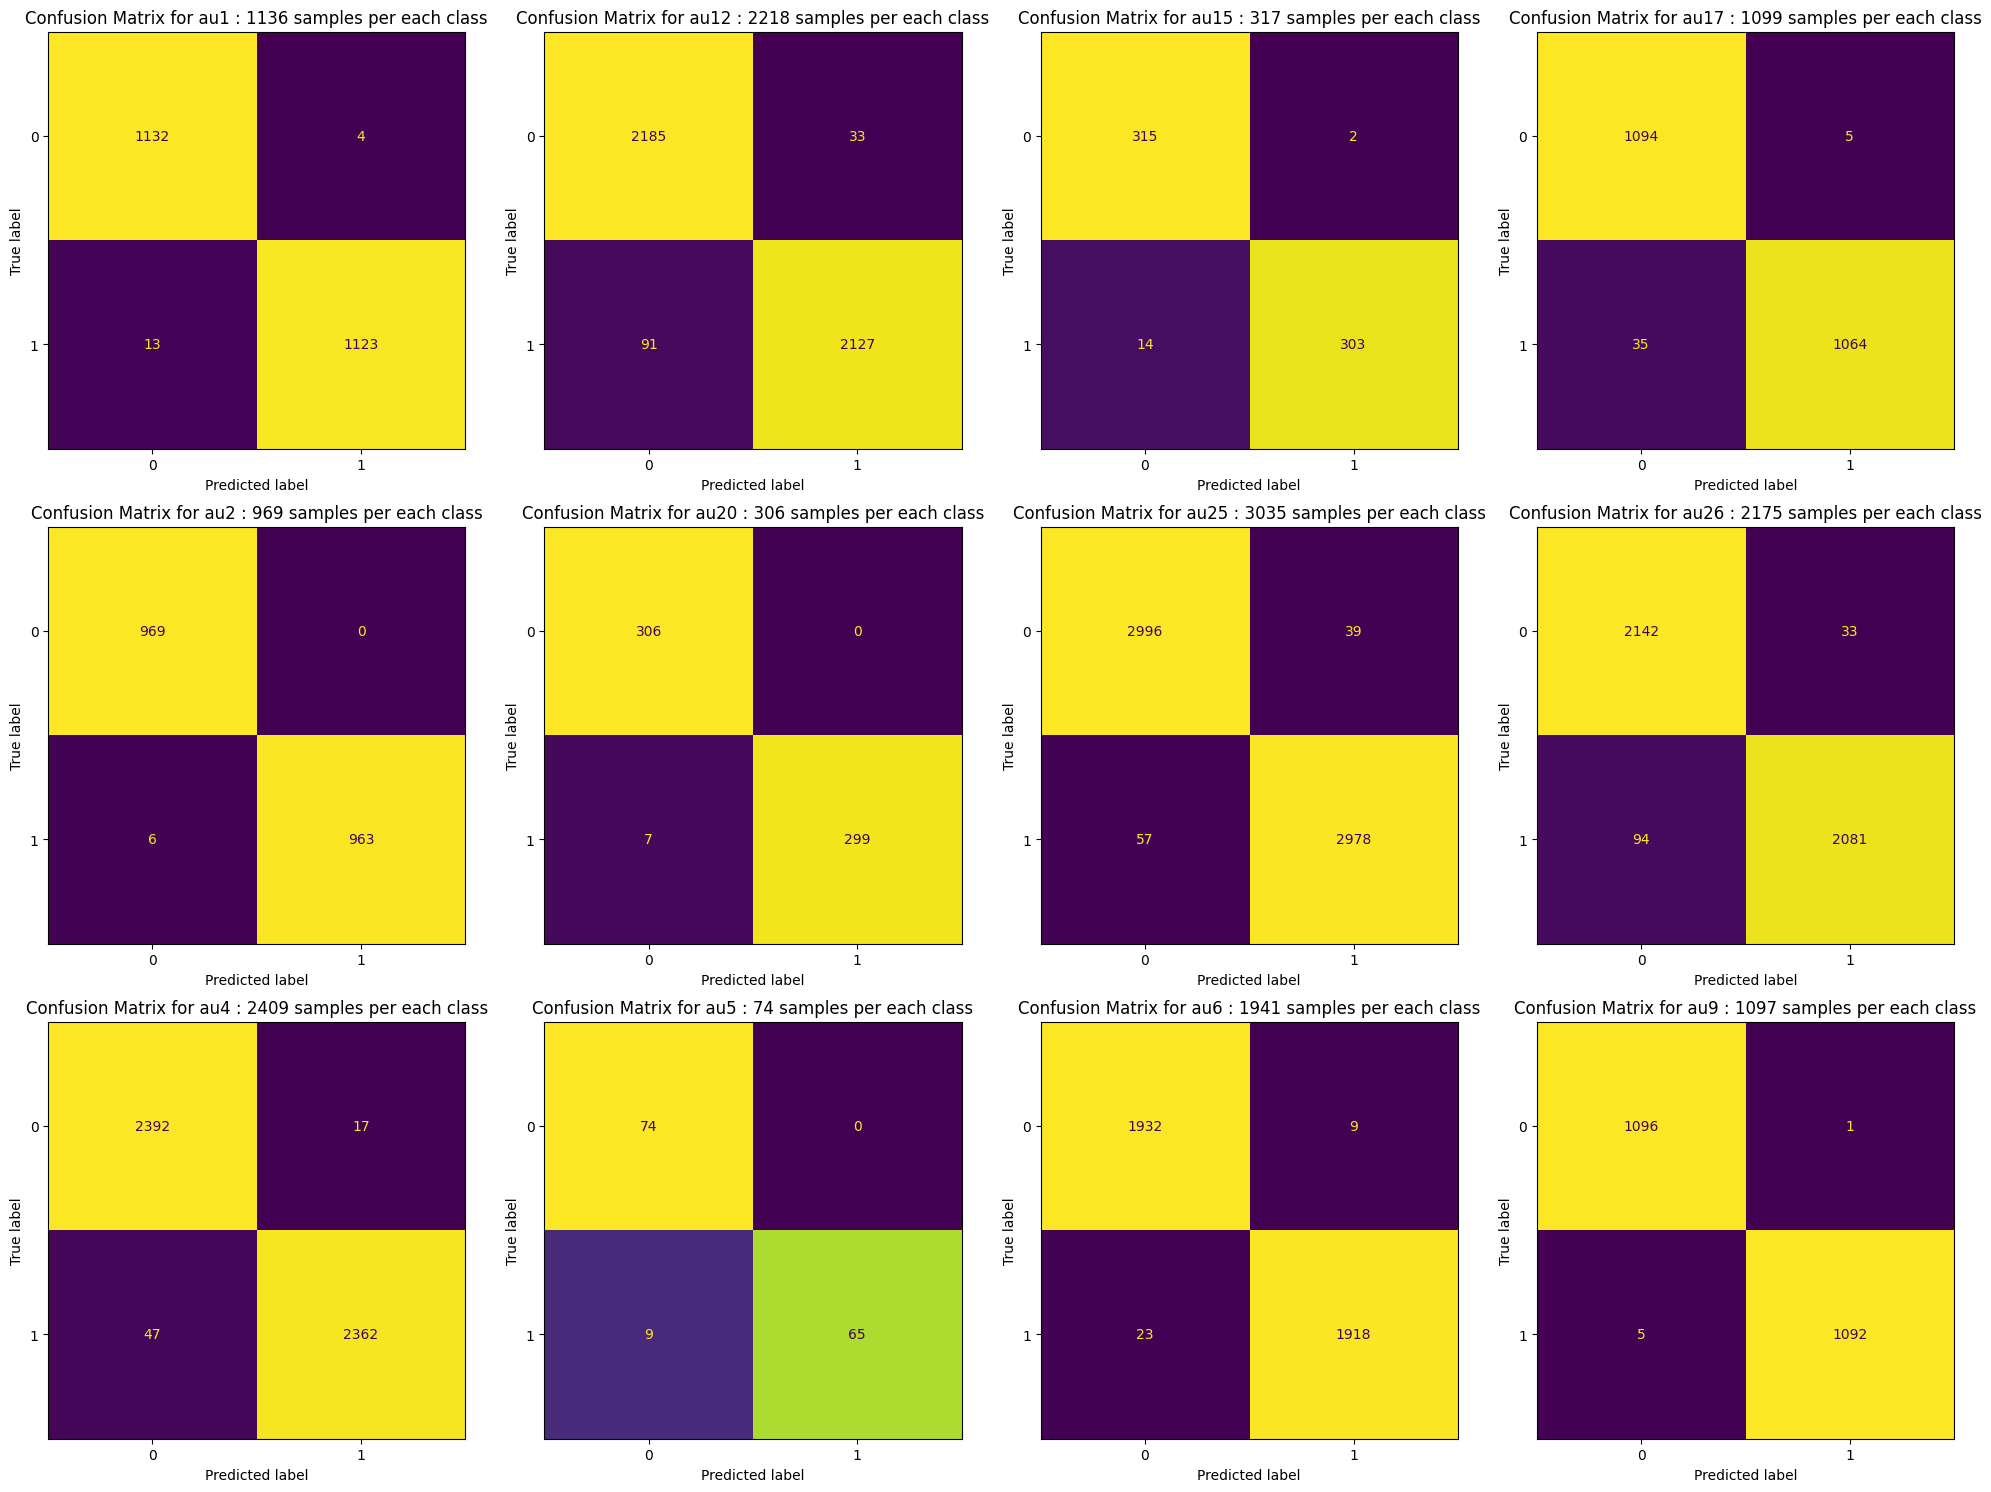

In [25]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
th = []

# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 4

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.flatten()

for i in range(12):
    zero_indices = np.where(test_labels[:, i] == 0)[0]
    one_indices = np.where(test_labels[:, i] == 1)[0]
    sam = min(len(one_indices), len(zero_indices))
    zero_samples = np.random.choice(zero_indices, sam, replace=False)
    mask = np.concatenate((zero_samples, one_indices))
    test = test_frames[mask]
    real = test_labels[mask]
    preds = model.predict(test)
    precision, recall, thresholds = precision_recall_curve(real[:, i], preds[:, i])

    # Compute F1 scores for the thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the index of the best F1 score
    best_index = np.argmax(f1_scores[:-1])
    best_threshold = thresholds[best_index]
    th.append(best_threshold)
    y_pred = (preds[:, i] >= t[i]).astype(int)
    cm = confusion_matrix(real[:, i], y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f"Confusion Matrix for {col[i]} : {sam} samples per each class")

# Adjust layout
plt.tight_layout()
plt.show()

In [26]:
history.history

{'accuracy': [0.33661141991615295,
  0.4084456264972687,
  0.42599761486053467,
  0.4371999502182007,
  0.43381860852241516,
  0.44011667370796204,
  0.4492798447608948,
  0.4505446255207062,
  0.4500025808811188,
  0.4530999958515167,
  0.4560167193412781,
  0.4610758423805237,
  0.46239224076271057,
  0.4696195423603058,
  0.46086934208869934,
  0.4675287902355194,
  0.46918073296546936,
  0.4714779853820801,
  0.4696711599826813,
  0.47362035512924194,
  0.47385266423225403,
  0.47145217657089233,
  0.4687677323818207,
  0.46900004148483276,
  0.47080686688423157,
  0.4767951965332031,
  0.47795674204826355,
  0.48397088050842285,
  0.4784729778766632,
  0.4778535068035126,
  0.4838676452636719,
  0.4792989492416382,
  0.47243303060531616,
  0.48446130752563477,
  0.4895978569984436,
  0.4868876039981842,
  0.4870166778564453,
  0.48469361662864685,
  0.4826286733150482,
  0.4856228530406952,
  0.4865262508392334,
  0.4924887716770172,
  0.49088844656944275,
  0.4808734655380249,
  

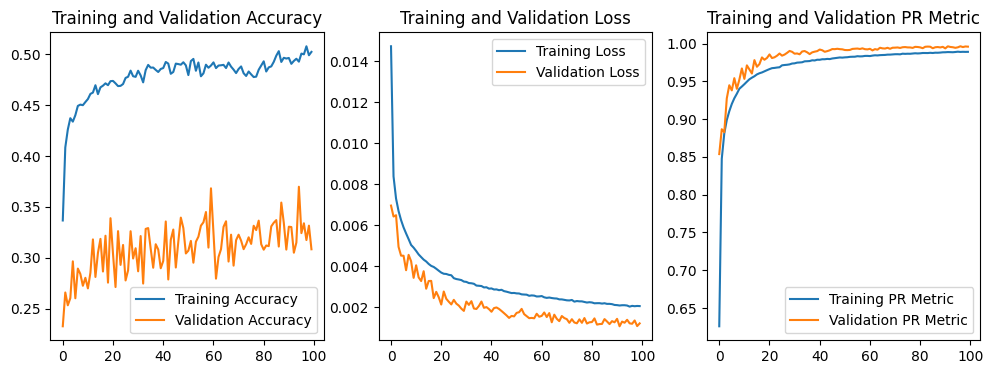

In [27]:
import matplotlib.pyplot as plt

# Extracting data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
pr_metric = history.history['auc']
val_pr_metric = history.history['val_auc']

epochs_range = range(len(acc))

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Plotting PR metric
plt.subplot(1, 3, 3)
plt.plot(epochs_range, pr_metric, label='Training PR Metric')
plt.plot(epochs_range, val_pr_metric, label='Validation PR Metric')
plt.legend(loc='lower right')
plt.title('Training and Validation PR Metric')

plt.show()


In [28]:
model.save('vit.keras')